**The purpose of this notebook is to build a image classifier to detect cases of pneumonia from normal cases by training the image classifier on the chest x-ray image dataset from kaggle. The modelling involves fine tuning a pretrained inception model using keras.**

In [0]:
##Load all the relevant libraries

import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout



In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path="/content/drive/My Drive/chest/"

# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Load the base model to look at the architecture. Some base models need a constant image size. In this case, its 150x150. Make the base model not trainable**

In [3]:
IMG_SHAPE = (150, 150, 3)
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")
base_model.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 3s 0us/step


**As we mentioned that include_top=FALSE for the base model, the top of the fine tuned model will have to be defined. As there will be two classes, the sigmoid function will be used.**

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

**Putting the base model and the new top together to define the model. Also compiling the model's tuned architecture before data generation and fitting.**

In [0]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

**As the model architecture has been fine tuned and defined and compiled, the next step is to setup the data generators:**

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.,horizontal_flip=True)
data_gen_valid = ImageDataGenerator(rescale=1/255.,horizontal_flip=True)


In [0]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical",shuffle=True)



In [0]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical",shuffle=True)

In [0]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical",shuffle=False)

Time to fit the model:

In [13]:
model.fit_generator(train_generator, epochs =5, validation_data = valid_generator)

Epoch 1/5
41/41 [==============================] - 1296s 32s/step - loss: 0.5155 - acc: 0.7880 - val_loss: 1.2327 - val_acc: 0.5625
Epoch 2/5
41/41 [==============================] - 61s 1s/step - loss: 0.3434 - acc: 0.8673 - val_loss: 1.6901 - val_acc: 0.5625
Epoch 3/5
41/41 [==============================] - 69s 2s/step - loss: 0.2784 - acc: 0.8944 - val_loss: 1.3036 - val_acc: 0.4375
Epoch 4/5
41/41 [==============================] - 69s 2s/step - loss: 0.2385 - acc: 0.9097 - val_loss: 1.4876 - val_acc: 0.5625
Epoch 5/5
41/41 [==============================] - 68s 2s/step - loss: 0.2254 - acc: 0.9130 - val_loss: 0.9863 - val_acc: 0.6875


In [20]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.6875


In [21]:
result = model.evaluate_generator(generator=test_generator, verbose=1)

5/5 [==============================] - 227s 45s/step - loss: 1.2289 - acc: 0.7260


In [0]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

ValueError: ignored

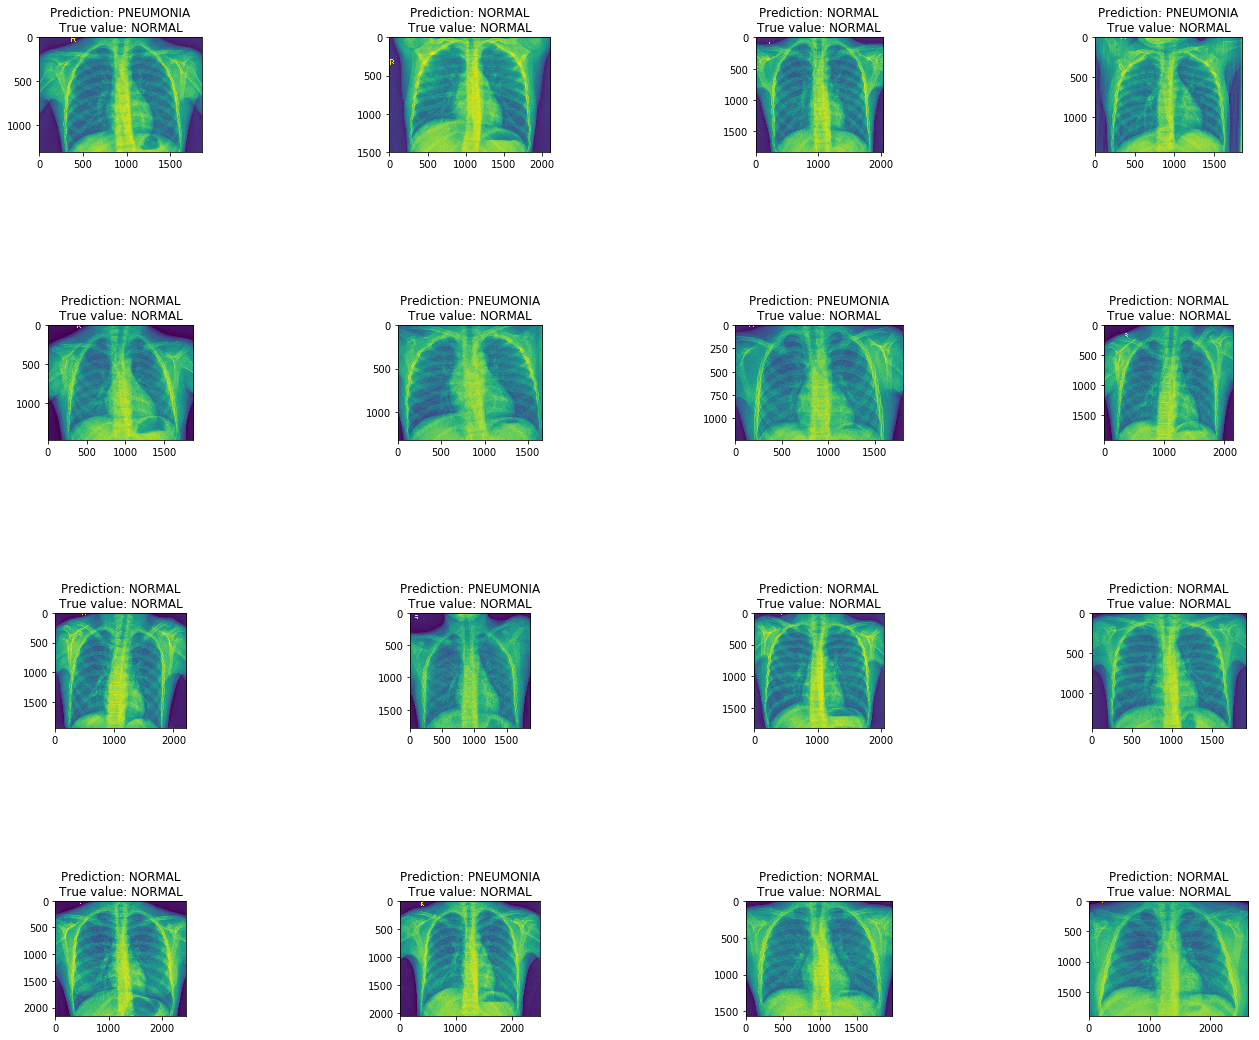

In [35]:
compare_results(test_dir, test_generator)